In [1]:
### GPU를 변경해서 해보기
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
## 경로 지정 후, 풀기 
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-02-07 05:33:39--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.214.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M   199MB/s    in 3.2s    

2020-02-07 05:33:43 (199 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [2]:
### 구글 드라이브 Colab 연동
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
### 훈련된 모델 사용
os.listdir('gdrive/My Drive/Colab Notebooks/naver_sentiment')

['bert.h5', 'bertembedding.pkl']

In [0]:
path = "gdrive/My Drive/Colab Notebooks/naver_sentiment"

In [5]:
### 모듈 임포트
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
# Bert 활용. Adam optimizer의 수정판(radam) 모듈 설치 및 임포트
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=2b5e543abe2ff21a6e784655963b31ad9a2788a866f3701ed529a28caf6329e0
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=712b0ee2b239fdb54652015df76e8e46bc92b42a7829825edf97e36850f1ffd7
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=d8245fd96b3e520c379eb2e93d125fb05f827732891d76c95ffc0b07ede4d8c5
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=8ae380bc95b66f73ff3c878e12630df9e5d91908f34527230562947c3c0d1eb6
  Stor

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [9]:
os.listdir('bert')

['bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt',
 'multi_cased_L-12_H-768_A-12',
 'bert_config.json']

In [10]:
### 네이버 감성분석 데이터 다운로드
!rm -rf nsmc
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [11]:
!rm -rf Korbert_Start
!git clone https://github.com/frontier1020/Korbert_Start

Cloning into 'Korbert_Start'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 4), reused 8 (delta 2), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [12]:
!ls -ls Korbert_Start

total 396
  4 -rw-r--r-- 1 root root   1002 Feb  7 05:35 korbert_start.ipynb
  4 -rw-r--r-- 1 root root     39 Feb  7 05:35 README.md
144 -rw-r--r-- 1 root root 146637 Feb  7 05:35 review_1500.csv
 52 -rw-r--r-- 1 root root  49825 Feb  7 05:35 review_500.csv
192 -rw-r--r-- 1 root root 196435 Feb  7 05:35 review_all.csv


In [13]:
os.listdir('nsmc')

['ratings.txt',
 'ratings_train.txt',
 'code',
 'raw',
 'ratings_test.txt',
 'README.md',
 'synopses.json',
 '.git']

In [0]:
# train = pd.read_table("nsmc/"+"ratings_train.txt")
# test = pd.read_table("nsmc/"+"ratings_test.txt")
train = pd.read_csv("Korbert_Start/"+"review_1500.csv")
test = pd.read_csv("Korbert_Start/"+"review_500.csv")

In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')     # 어떤 설정이 들어가있을까?
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')  # ckpt는 기존에 학습된 가중치
vocab_path = os.path.join(pretrained_path, 'vocab.txt')  # 토큰화할때 사용하는 단어..

# DATA_COLUMN = "document"
# LABEL_COLUMN = "label"
DATA_COLUMN = "리뷰"
LABEL_COLUMN = "감정판단"

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
### inherit_Tokenizer클래스는 문장을 토큰화하는 기능을 한다.
### 한국어할때 꼭 해야 한다. 
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [0]:
### 구체적으로 무엇을 하는가?
tokenizer = inherit_Tokenizer(token_dict)

In [30]:
tokenizer.tokenize("케라스로 버트 해보기 정말 재밌음.")

['[CLS]',
 '케',
 '##라',
 '##스로',
 '버',
 '##트',
 '해',
 '##보',
 '##기',
 '정',
 '##말',
 '재',
 '##밌',
 '##음',
 '.',
 '[SEP]']

In [0]:
### 네이버 영화 댓글 감성분석 데이터 - 버트 모형에 맞춰 변형해주는 함수
### 함수 내부의 tokenizer.encode가 함수가 버튼 모형을 토큰화 해준다. 
### 토큰화된 단어를 인덱스에 맞게 숫자로 변경.
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df[LABEL_COLUMN][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [32]:
print(train.shape)
print(train.columns)

(1698, 3)
Index(['리뷰', '점수', '감정판단'], dtype='object')


In [34]:
## 데이터를 학습용 X, y로 나누어준다.
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)
# sel = ['리뷰']
# train_x = train[sel]
# test_x = test[sel]

# train_y = train['감정판단']
# test_y = test['감정판단']

100%|██████████| 562/562 [00:00<00:00, 7001.99it/s]


In [35]:
print(len(train_x))
print(len(train_x[0]))
print(len(train_x[1]))
print(train_x[0][0])
print(len( train_x[0][0]) )   # SEQ_LEN = 128 이기 때문에?
print(type(train_x) )

2
1698
1698
[   101   9288  43022  10892   9834  11664   9284  10892   9004  32537
   9131   9256  16985 118836  12965  12508  28578   9284  14646  37712
   9706  68984  11513   9682   8996  26737  16323  14867   9708 119235
   9924  12453   9130 118848  17594   9654   9645 119470  15891  13767
   9122  86150  10739  96279  48549    198   9663  49515   8853  16985
  80795  26565  22224   9685  16985  12178   9588  10739  27792   9952
  17196  48549   9121 118666  57362   8934  12965  12424   9558 118787
  10739  18382   9082  10739  25503 118671   9284  12508  68984  19105
   8996  26737  12424   9645  18108  14867   9006  49881  11102  28911
   9130 118848  11102  12508   9553  40311   9924  14523  35506  54141
  17342  17196  48549    198  23289   9706  68984  11287   9121  84457
   9061  26737  12424   9689  12030   9645  96006  11018   9706  68984
 119198  78136  12310   9924  35506  17196   8853    102]
128
<class 'list'>


In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [37]:
sentence_load_data(["케라스로 버트 해보기 정말 재밌음", "케라스 쉬워 쉬워"])

100%|██████████| 2/2 [00:00<00:00, 1429.55it/s]

['[CLS]', '케', '##라', '##스로', '버', '##트', '해', '##보', '##기', '정', '##말', '재', '##밌', '##음', '[SEP]']
['[CLS]', '케', '##라', '##스', '쉬', '##워', '쉬', '##워', '[SEP]']


[array([[  101,  9806, 17342, 94980,  9336, 15184,  9960, 30005, 12310,
          9670, 89523,  9659,   100, 32158,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,

In [0]:
### 구글 깃허브에서 받았던 사전 학습 모델을 colab으로 로드
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [39]:
### 모델의 구조 확인. 총 12층의 트랜스포머 계층 있음.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
### 사전 학습 모델을 outputs=Dense(1) 사전학습 모델에 Dense(1)을 애드온 시켜준다.
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

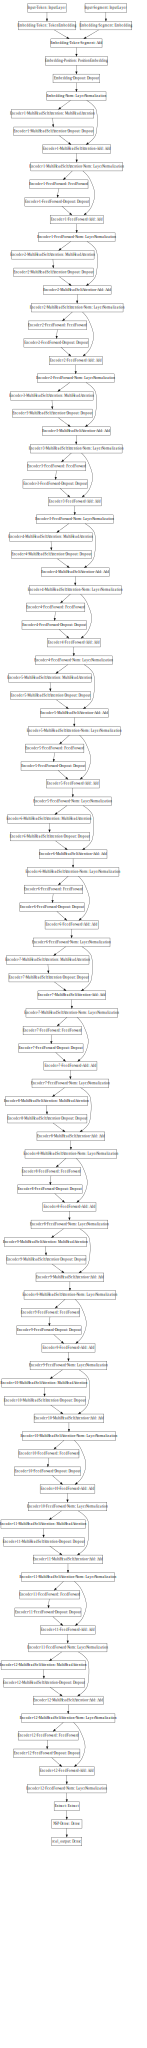

In [41]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [42]:
### 훈련
### 조금 시간이 걸리고 보통 4epoch를 돌려준다. 
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)


Train on 1698 samples, validate on 562 samples
Epoch 1/2
1698/1698 [==============================] - 81s 48ms/step - loss: 0.5188 - acc: 0.7120 - val_loss: 0.3431 - val_acc: 0.8932
Epoch 2/2
1698/1698 [==============================] - 66s 39ms/step - loss: 0.3146 - acc: 0.9058 - val_loss: 0.3419 - val_acc: 0.8932


In [43]:
path  # 재사용을 위해 : bert_model를 지드라이브에 저장.

'gdrive/My Drive/Colab Notebooks/naver_sentiment'

In [0]:
bert_model.save_weights(path+"/bert_naver.h5")

In [0]:
### 버트 모형을 로드
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path+"/bert_naver.h5")

In [0]:
## 테스트 데이터를 버트 모형에 넣도록 predict_convert_data 함수를 정의해준다.
## convert_data함수와 다른 점. test 데이터이기때문에 label은 고려하지 않음.

def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

In [47]:
test_set = predict_load_data(test)

100%|██████████| 562/562 [00:00<00:00, 5293.13it/s]


In [48]:
type(test_set)

list

In [0]:
### 테스트 셋으로 예측하기 - 예측 시간 5-10분 정도
preds = bert_model.predict(test_set)

In [50]:
print(len(preds))
print(preds[0:10])

562
[[0.9018134 ]
 [0.9216085 ]
 [0.90017045]
 [0.9211694 ]
 [0.92105806]
 [0.92105806]
 [0.92105806]
 [0.92105806]
 [0.92105806]
 [0.9239358 ]]


In [0]:
from sklearn.metrics import classification_report

In [52]:
y_true = test['감정판단']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.89      1.00      0.94       502

    accuracy                           0.89       562
   macro avg       0.45      0.50      0.47       562
weighted avg       0.80      0.89      0.84       562



In [53]:
bert_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [54]:
bert_model.input

[<tf.Tensor 'Input-Token:0' shape=(?, 128) dtype=float32>,
 <tf.Tensor 'Input-Segment:0' shape=(?, 128) dtype=float32>]

In [55]:
bert_model.layers[-2].output

<tf.Tensor 'NSP-Dense/Tanh:0' shape=(?, 768) dtype=float32>

In [0]:
### 마지막 768개의 피쳐를 부분을 잘라낸다.
### 768개의 피쳐를 추출하여 마지막 768개의 값으로 반환
def get_feature_map(model):
  inputs = model.input
  print(inputs)
  outputs = model.layers[-2].output
  print(outputs)
  feature_model = Model(inputs, outputs)
  return feature_model

In [57]:
bert_feature = get_feature_map(bert_model)
print(type(bert_feature))

[<tf.Tensor 'Input-Token:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'Input-Segment:0' shape=(?, 128) dtype=float32>]
Tensor("NSP-Dense/Tanh:0", shape=(?, 768), dtype=float32)
<class 'keras.engine.training.Model'>


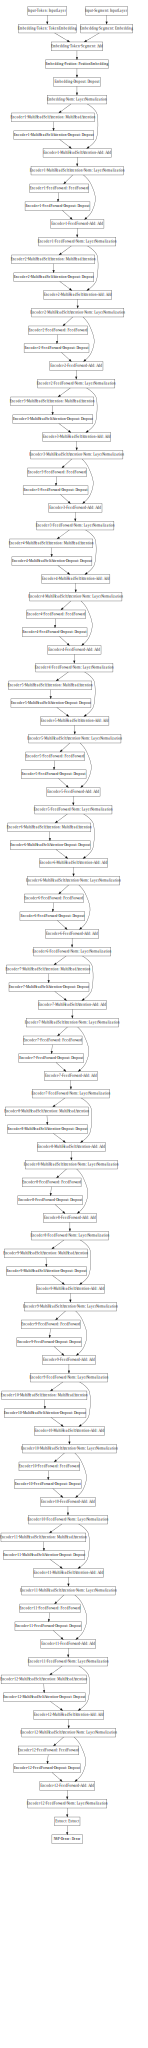

In [58]:
SVG(model_to_dot(bert_feature, dpi=65).create(prog='dot', format='svg'))

In [0]:
bert_weight_list = bert_feature.predict(test_set)

In [60]:
bert_weight_list

array([[ 0.6828799 , -0.02043024, -0.41236988, ...,  0.02491555,
        -0.20847838,  0.5723324 ],
       [ 0.7326329 ,  0.05793576, -0.38561687, ..., -0.09265438,
        -0.04449551,  0.71431464],
       [ 0.684451  , -0.01111879, -0.40757632, ...,  0.02379242,
        -0.20902139,  0.56579643],
       ...,
       [ 0.59246016,  0.19493346, -0.35058206, ...,  0.17957367,
        -0.3552359 ,  0.38669425],
       [ 0.65029085, -0.01404175, -0.47102937, ..., -0.0573893 ,
        -0.22459672,  0.6582842 ],
       [ 0.56606567,  0.06693152, -0.3199464 , ...,  0.08612082,
        -0.13806386,  0.502612  ]], dtype=float32)

In [0]:
labels = test['감정판단']

In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [64]:
## PCA를 사용하여 256차원으로 줄임.
### TSNE알고리즘을 이용하여 3차원으로 축소
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=3).fit_transform(bert_embedded)
bert_embedded

array([[ 65.24874   ,  -4.6771293 , -14.651972  ],
       [-52.94564   , -20.016573  , -93.212494  ],
       [ 60.86773   ,  -6.999553  ,  -4.6026826 ],
       ...,
       [ 52.687714  , -44.40982   , -36.46059   ],
       [-25.353447  , -18.800629  ,  41.893227  ],
       [ 50.85989   ,   0.50108165, -64.85423   ]], dtype=float32)

In [65]:
path

'gdrive/My Drive/Colab Notebooks/naver_sentiment'

In [0]:
## 추후 임베딩을 위해 pickle모듈을 저장해 주기 
with open(path+"/bertembedding.pkl", "wb") as f:
  pickle.dump(bert_embedded, f)

In [0]:
## 임베딩 로드
with open(path+"/bertembedding.pkl", "rb") as f:
  bert_embedded = pickle.load(f)

In [0]:
## 3D을 그리기 위해 matplotlib 모듈을 로드
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import seaborn as sns

In [69]:
test

,리뷰,점수,감정판단
0,"가슴둘레 딱 40cm입니다. 혹시 몰라 사이즈 문의했을때 ,신축성이 없으니 크게 주...",4,1
1,좋어요 감사합니다호,4,1
2,"가슴둘레 딱 40cm입니다. 혹시 몰라 사이즈 문의했을때 ,신축성이 없으니 크게 주...",5,1
3,좋어요 감사합니다ㅎㅎㅎ,5,1
4,강아지가 좋아해요ㅎㅎㅎ,5,1
...,...,...,...
557,"저렴한 가격의 따뜻한 겨울옷 득템! 가격도 저렴하고, 색상도 흰 털 말티즈에게 잘 ...",5,1
558,"말티즈한테 입히니 흰털이라 잘 어울리고, 품도 넉넉하네요.",5,1
559,지난 번 독브라운 그레이색 구매해서 입혔는데.. 정말 잘 어울려서 빨강색도 추가 구...,5,1
560,색이 예뻐요 근데 본드가 묻어나와서 좀ㅠ,5,1


In [0]:
def get_tsne_plot(rot1=-20, rot2=100):
  fig = plt.figure(figsize=(5,5))
  ax = Axes3D(fig)
  colors = 'b', 'r'
  labels = 0, 1
  for i, c, label in zip(range(np.shape(bert_embedded)[0]), colors, labels):
    ax.scatter(bert_embedded[test['감정판단']==label,0], bert_embedded[test['감정판단']==label,1], bert_embedded[test['감정판단']==label,2], s=2, c=c, alpha=0.5)
  ax.view_init(rot1, rot2)
  print("rot1:%d" % rot1, "rot2:%d" % rot2)
  plt.legend(labels, loc='upper right')
  plt.show()

rot1:-180 rot2:-180


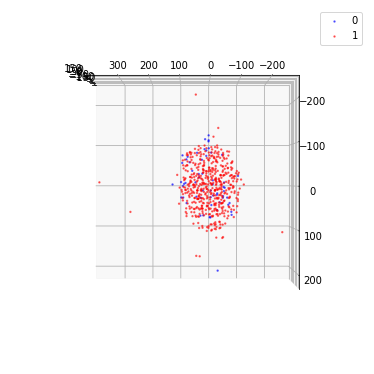

rot1:-135 rot2:-180


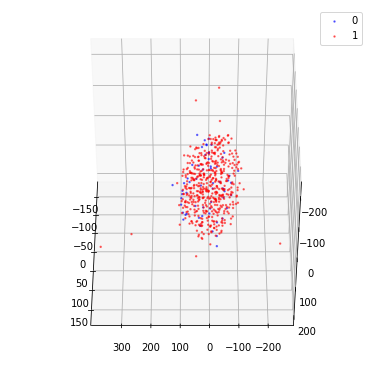

rot1:-90 rot2:-180


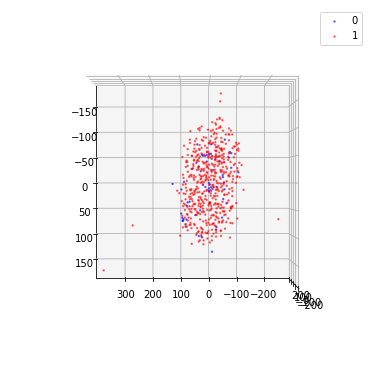

rot1:-45 rot2:-180


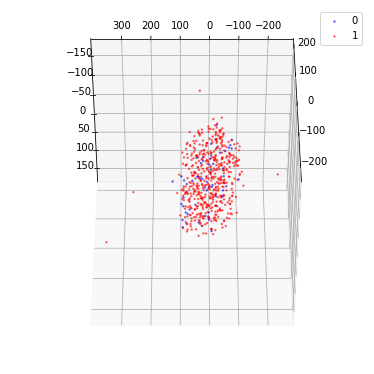

rot1:0 rot2:-180


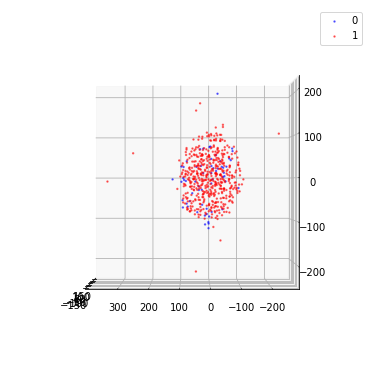

rot1:45 rot2:-180


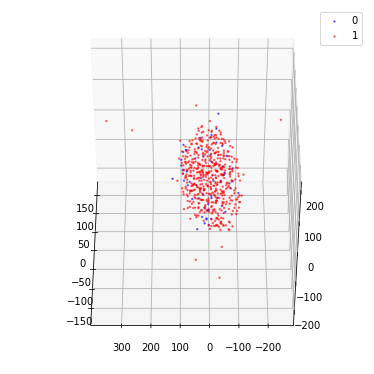

rot1:90 rot2:-180


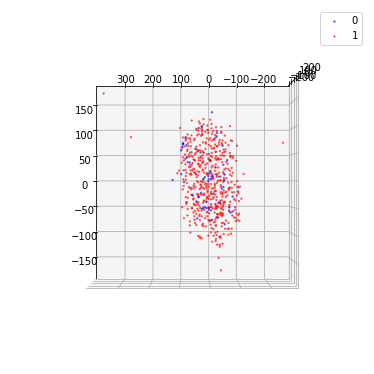

rot1:135 rot2:-180


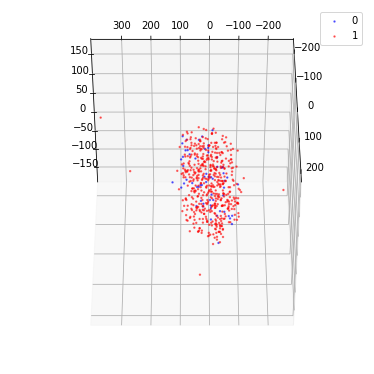

rot1:-180 rot2:-135


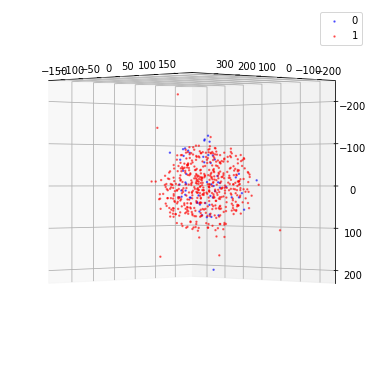

rot1:-135 rot2:-135


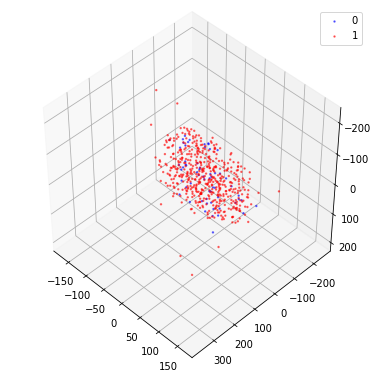

rot1:-90 rot2:-135


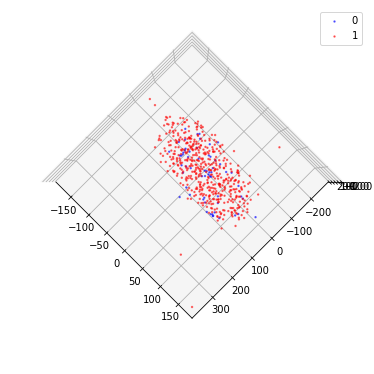

rot1:-45 rot2:-135


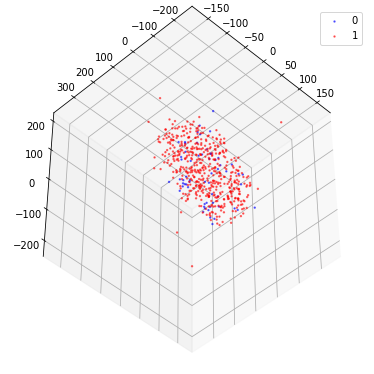

rot1:0 rot2:-135


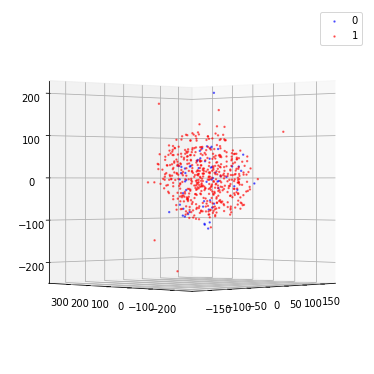

rot1:45 rot2:-135


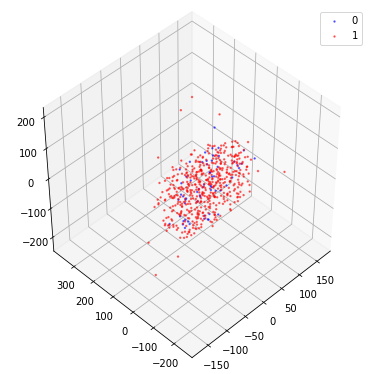

rot1:90 rot2:-135


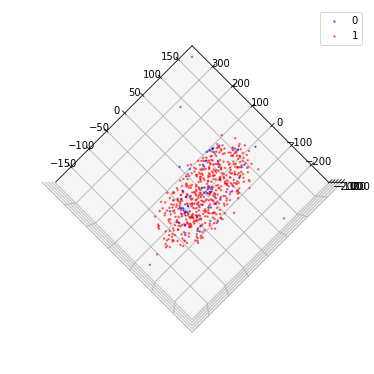

rot1:135 rot2:-135


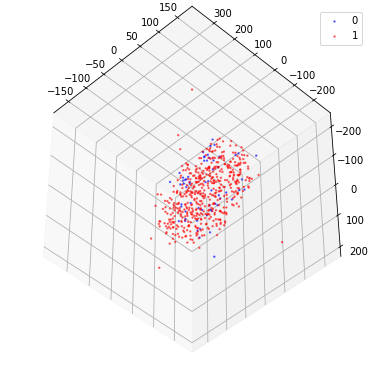

rot1:-180 rot2:-90


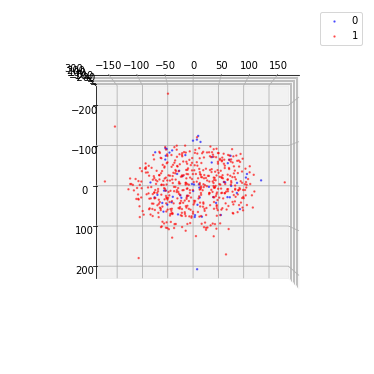

rot1:-135 rot2:-90


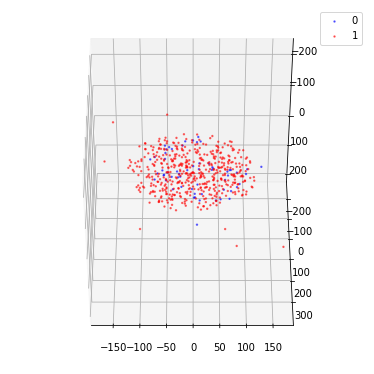

rot1:-90 rot2:-90


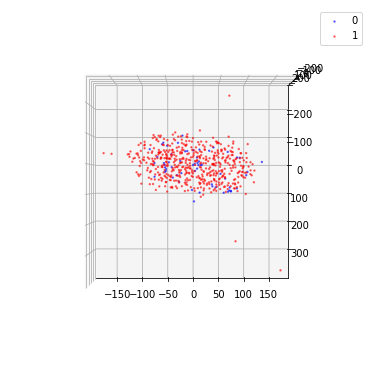

rot1:-45 rot2:-90


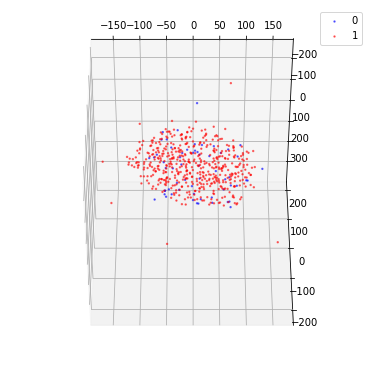

rot1:0 rot2:-90


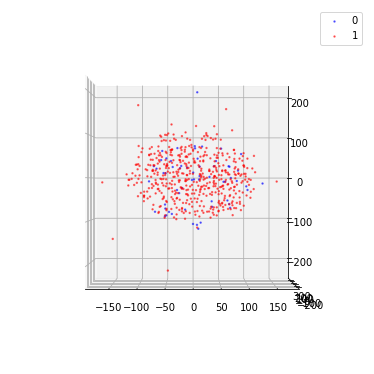

rot1:45 rot2:-90


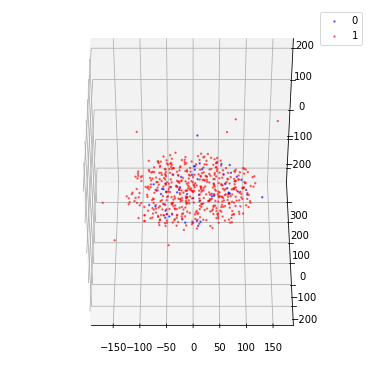

rot1:90 rot2:-90


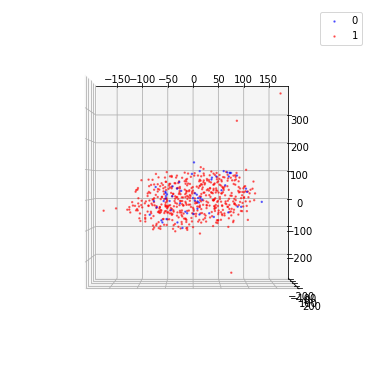

rot1:135 rot2:-90


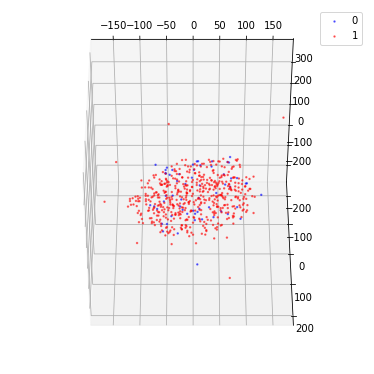

rot1:-180 rot2:-45


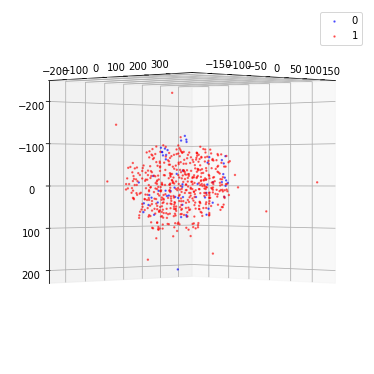

rot1:-135 rot2:-45


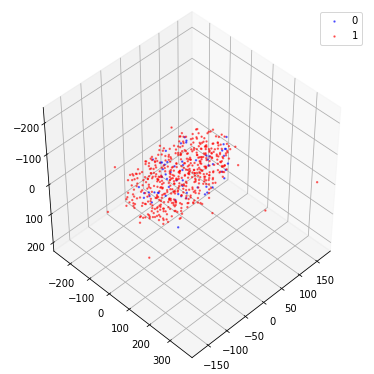

rot1:-90 rot2:-45


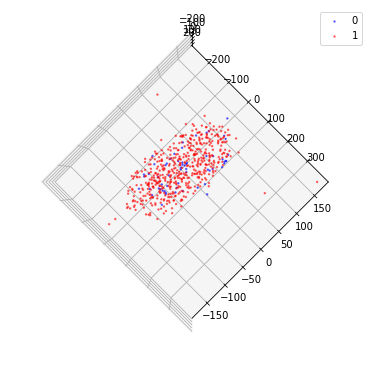

rot1:-45 rot2:-45


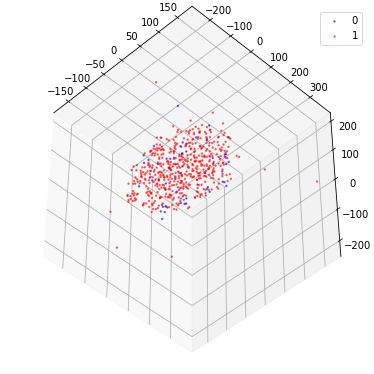

rot1:0 rot2:-45


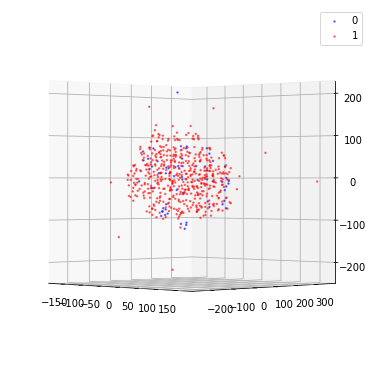

rot1:45 rot2:-45


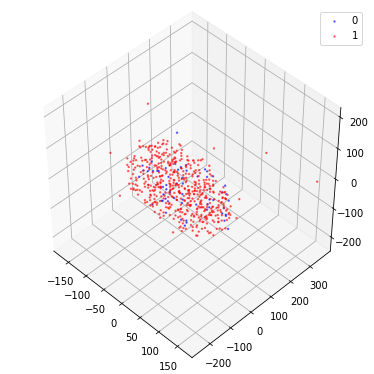

rot1:90 rot2:-45


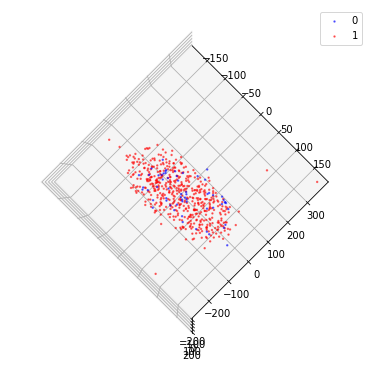

rot1:135 rot2:-45


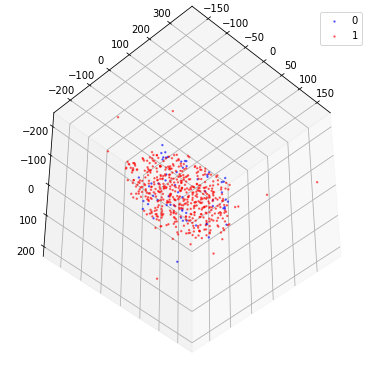

rot1:-180 rot2:0


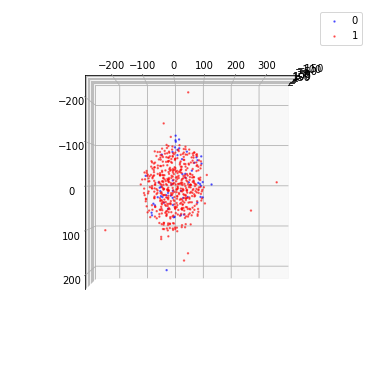

rot1:-135 rot2:0


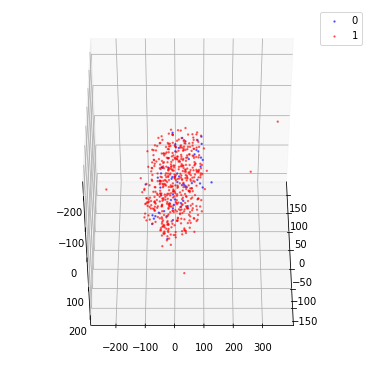

rot1:-90 rot2:0


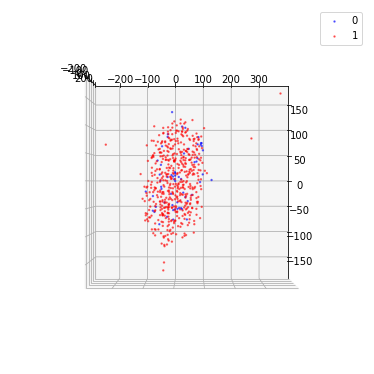

rot1:-45 rot2:0


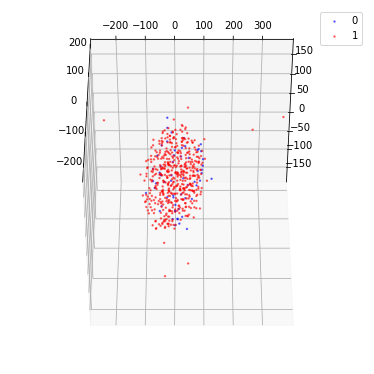

rot1:0 rot2:0


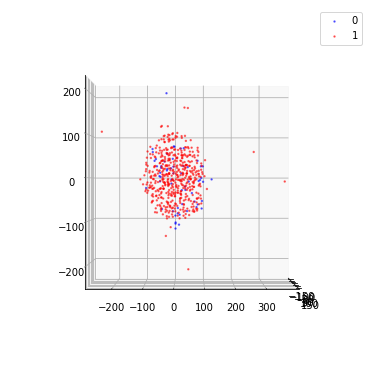

rot1:45 rot2:0


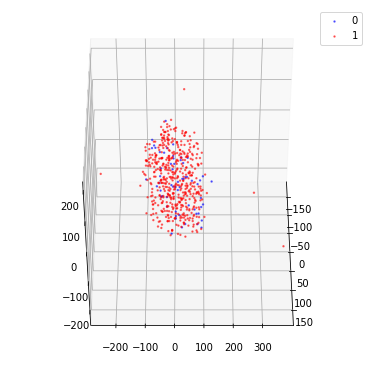

rot1:90 rot2:0


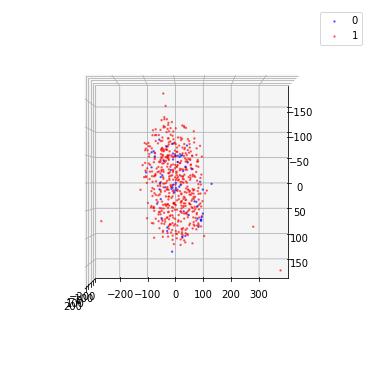

rot1:135 rot2:0


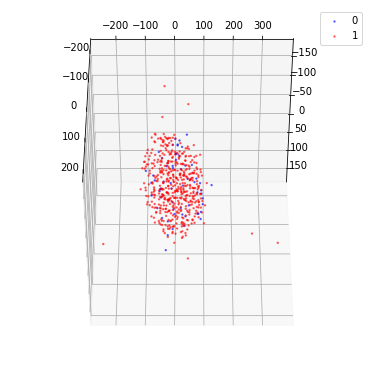

rot1:-180 rot2:45


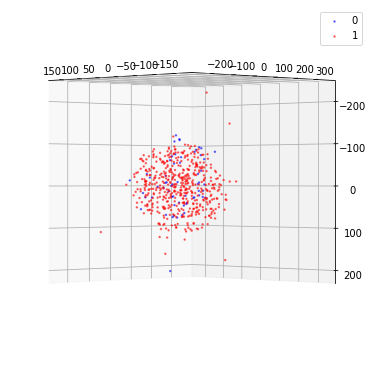

rot1:-135 rot2:45


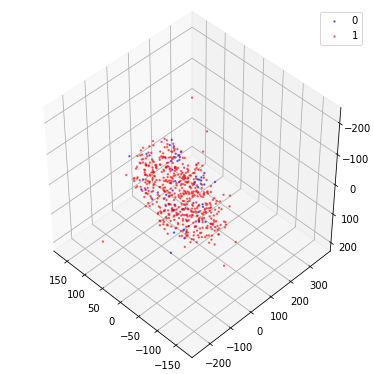

rot1:-90 rot2:45


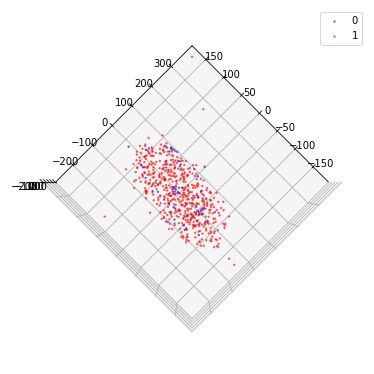

rot1:-45 rot2:45


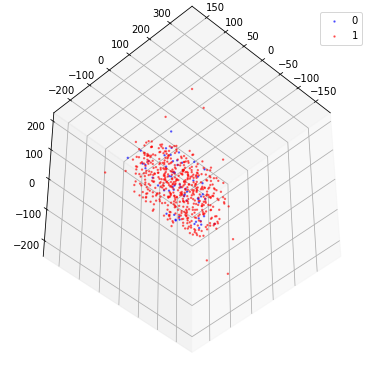

rot1:0 rot2:45


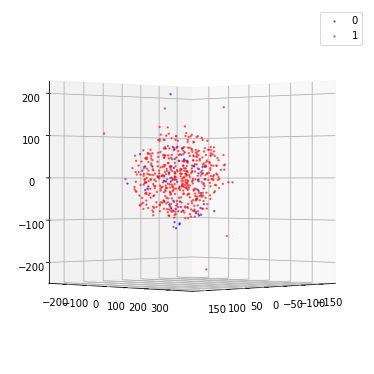

rot1:45 rot2:45


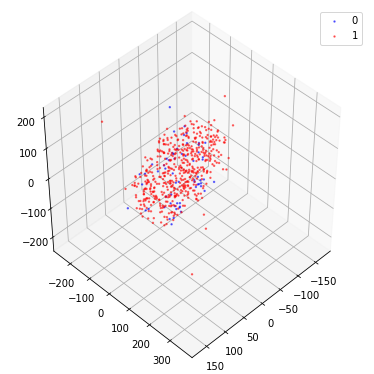

rot1:90 rot2:45


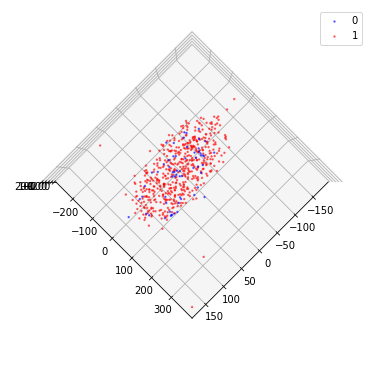

rot1:135 rot2:45


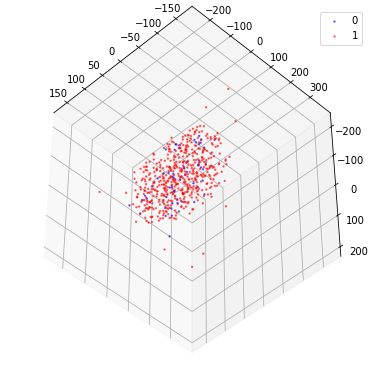

rot1:-180 rot2:90


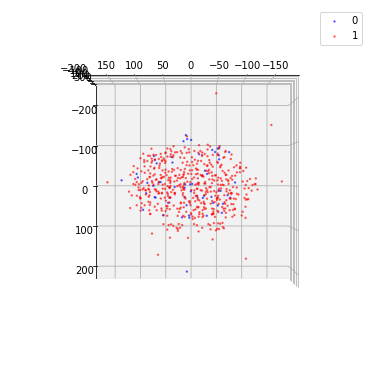

rot1:-135 rot2:90


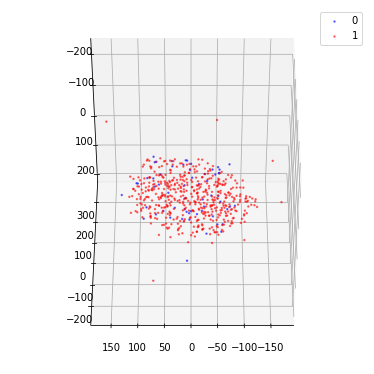

rot1:-90 rot2:90


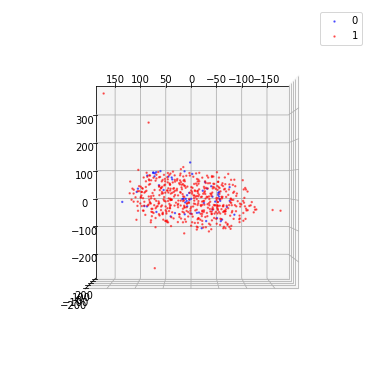

rot1:-45 rot2:90


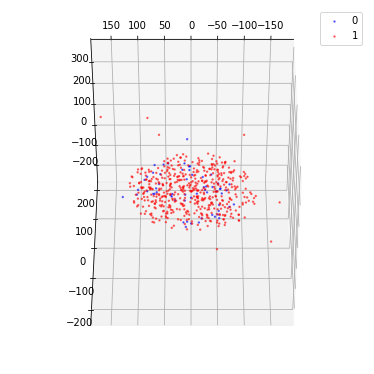

rot1:0 rot2:90


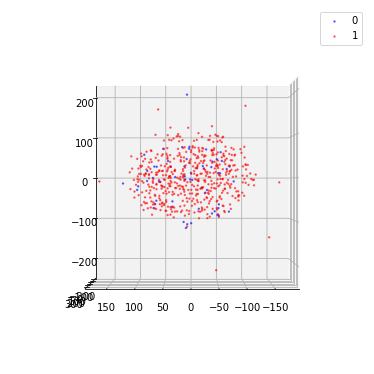

rot1:45 rot2:90


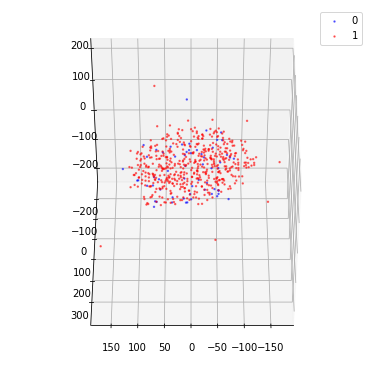

rot1:90 rot2:90


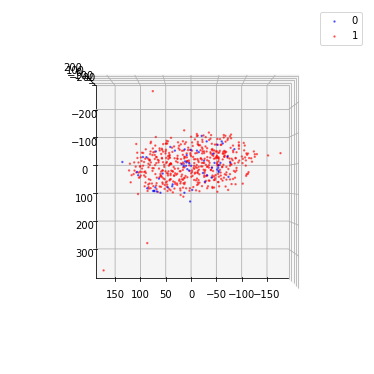

rot1:135 rot2:90


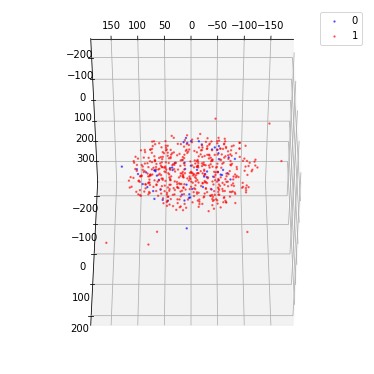

rot1:-180 rot2:135


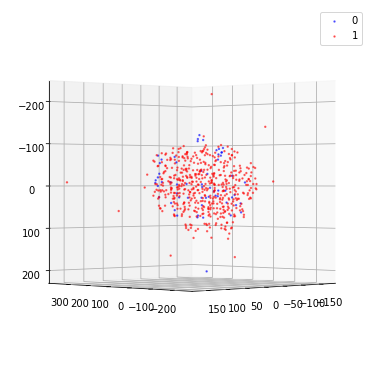

rot1:-135 rot2:135


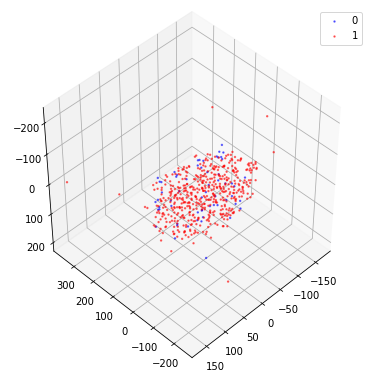

rot1:-90 rot2:135


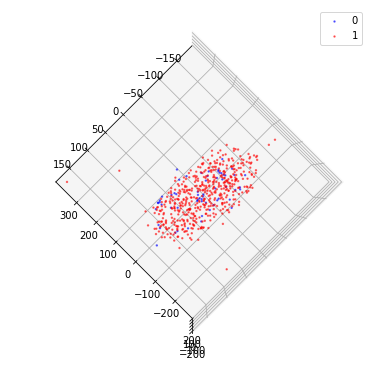

rot1:-45 rot2:135


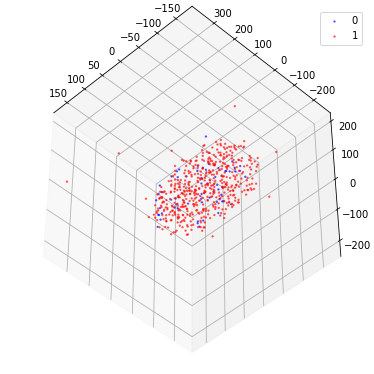

rot1:0 rot2:135


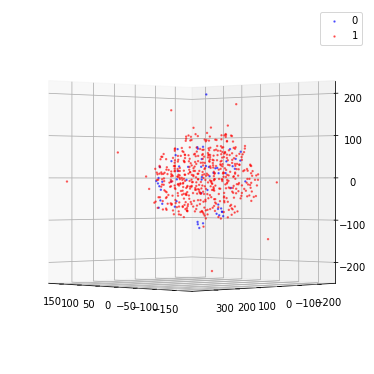

rot1:45 rot2:135


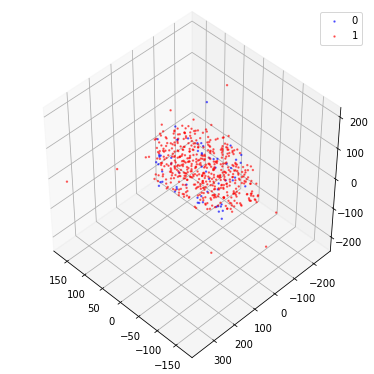

rot1:90 rot2:135


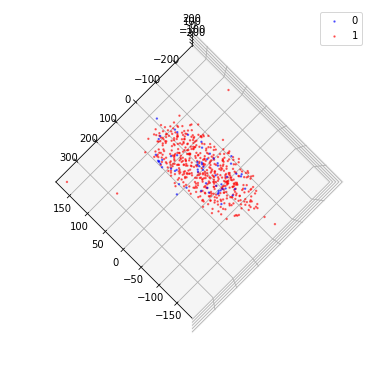

rot1:135 rot2:135


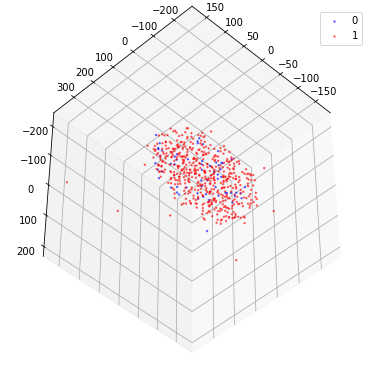

In [73]:
import time
for j in range(-180, 180, 45):
  for i in range(-180,180,45):
    get_tsne_plot(i, j)
